# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Собираем-сиамскую-сеть" data-toc-modified-id="Собираем-сиамскую-сеть-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Собираем сиамскую сеть</a></div><div class="lev1 toc-item"><a href="#Проверяем-глубокое-представление" data-toc-modified-id="Проверяем-глубокое-представление-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Проверяем глубокое представление</a></div>

In [1]:
import numpy as np
import lasagne
import theano
import theano.tensor as T
from lasagne.nonlinearities import rectify, sigmoid, linear, tanh
from lasagne.layers import InputLayer, DenseLayer, BatchNormLayer, Upscale2DLayer, NonlinearityLayer, ReshapeLayer
from lasagne.layers import Conv2DLayer, MaxPool2DLayer, dropout

import matplotlib.pyplot as plt
%matplotlib inline

# import gzip, pickle

In [2]:
# Seed for reproducibility
np.random.seed(42)

In [3]:
files = np.load('data_set160.npz')
X_train, y_train, X_val, y_val = files['X_train'], files['y_train'], files['X_test'], files['y_test']
# Load training and test splits as numpy arrays
# train, val, test = pickle.load(gzip.open('mnist.pkl.gz'))

# X_train, y_train = train
# X_val, y_val = val

In [4]:
second_dim = 1
img_size = 160
print(X_train.shape, X_val.shape)

# second_dim = 1
# img_size = 28
# X_train = X_train.reshape([-1,1,28,28])
# X_val = X_val.reshape([-1,1,28,28])

((11450, 1, 160, 160), (1783, 1, 160, 160))


# Собираем сиамскую сеть

In [5]:
input_image_left  = T.tensor4('input_left')
input_image_positive = T.tensor4('input_positive')
input_image_negative = T.tensor4('input_negative')

In [6]:
l_input = InputLayer(shape=(None, second_dim, img_size, img_size), input_var=input_image_left)
p_input = InputLayer(shape=(None, second_dim, img_size, img_size), input_var=input_image_positive)
n_input = InputLayer(shape=(None, second_dim, img_size, img_size), input_var=input_image_negative)

In [7]:
conv1_filter_size = 3
conv1_num_filters = 64
conv1_pad = 1
conv1_stride = 1

conv2_filter_size = 3
conv2_num_filters = 128
conv2_pad = 1
conv2_stride = 1

conv3_filter_size = 3
conv3_num_filters = 256
conv3_stride = 1
conv3_pad = 1

conv4_filter_size = 3
conv4_num_filters = 512
conv4_stride = 1
conv4_pad = 1

conv5_filter_size = 3
conv5_num_filters = 512
conv5_stride = 1
conv5_pad = 1

pool1_size = 2
pool2_size = 2
pool3_size = 2
pool4_size = 2
pool5_size = 2

dense_layer1_size = 1024
dense_layer2_size = 512

In [8]:
my_nonlin = rectify
net = Conv2DLayer(l_input, conv1_num_filters, conv1_filter_size, pad=conv1_pad, stride=conv1_stride,
                  nonlinearity=my_nonlin,
                  W=lasagne.init.GlorotUniform())
net = MaxPool2DLayer(net, pool1_size)
net = Conv2DLayer(net, conv2_num_filters, conv2_filter_size, pad=conv2_pad, stride=conv2_stride,
                  nonlinearity=my_nonlin)
net = MaxPool2DLayer(net, pool2_size)
net = Conv2DLayer(net, conv3_num_filters, conv3_filter_size, pad=conv3_pad, stride=conv3_stride,
                  nonlinearity=my_nonlin)
net = MaxPool2DLayer(net, pool3_size)
net = Conv2DLayer(net, conv4_num_filters, conv4_filter_size, pad=conv4_pad, stride=conv4_stride,
                  nonlinearity=my_nonlin)
net = MaxPool2DLayer(net, pool4_size)
net = Conv2DLayer(net, conv5_num_filters, conv5_filter_size, pad=conv5_pad, stride=conv5_stride,
                  nonlinearity=my_nonlin)
net = MaxPool2DLayer(net, pool5_size)
net = DenseLayer(dropout(net, p=.5), num_units=dense_layer1_size, nonlinearity=my_nonlin)
nn_l_out = DenseLayer(dropout(net, p=.5), num_units=dense_layer2_size, nonlinearity=my_nonlin)

In [9]:
l_params = lasagne.layers.get_all_params(nn_l_out)
l_params

[W, b, W, b, W, b, W, b, W, b, W, b, W, b]

In [10]:
net = Conv2DLayer(p_input, conv1_num_filters, conv1_filter_size, pad=conv1_pad, stride=conv1_stride, nonlinearity=my_nonlin,
                      W=l_params[0], b=l_params[1])
net = MaxPool2DLayer(net, pool1_size)
net = Conv2DLayer(net, conv2_num_filters, conv2_filter_size, pad=conv2_pad, stride=conv2_stride, nonlinearity=my_nonlin,
                  W=l_params[2], b=l_params[3])
net = MaxPool2DLayer(net, pool2_size)
net = Conv2DLayer(net, conv3_num_filters, conv3_filter_size, pad=conv3_pad, stride=conv3_stride, nonlinearity=my_nonlin,
                  W=l_params[4], b=l_params[5])
net = MaxPool2DLayer(net, pool3_size)
net = Conv2DLayer(net, conv4_num_filters, conv4_filter_size, pad=conv4_pad, stride=conv4_stride,
                  nonlinearity=my_nonlin,
                  W=l_params[6], b=l_params[7])
net = MaxPool2DLayer(net, pool4_size)
net = Conv2DLayer(net, conv5_num_filters, conv5_filter_size, pad=conv5_pad, stride=conv5_stride,
                  nonlinearity=my_nonlin,
                  W=l_params[8], b=l_params[9])
net = MaxPool2DLayer(net, pool5_size)
net = DenseLayer(dropout(net, p=0.5), num_units=dense_layer1_size, nonlinearity=my_nonlin,
                 W=l_params[10], b=l_params[11])
nn_p_out = DenseLayer(dropout(net, p=0.5), num_units=dense_layer2_size, nonlinearity=my_nonlin,
                 W=l_params[12], b=l_params[13])

In [11]:
net = Conv2DLayer(n_input, conv1_num_filters, conv1_filter_size, pad=conv1_pad, stride=conv1_stride,
                      nonlinearity=my_nonlin,
                      W=l_params[0], b=l_params[1])
net = MaxPool2DLayer(net, pool1_size)
net = Conv2DLayer(net, conv2_num_filters, conv2_filter_size, pad=conv2_pad, stride=conv2_stride,
                  nonlinearity=my_nonlin,
                  W=l_params[2], b=l_params[3])
net = MaxPool2DLayer(net, pool2_size)
net = Conv2DLayer(net, conv3_num_filters, conv3_filter_size, pad=conv3_pad, stride=conv3_stride,
                  nonlinearity=my_nonlin,
                  W=l_params[4], b=l_params[5])
net = MaxPool2DLayer(net, pool3_size)
net = Conv2DLayer(net, conv4_num_filters, conv4_filter_size, pad=conv4_pad, stride=conv4_stride,
                  nonlinearity=my_nonlin,
                  W=l_params[6], b=l_params[7])
net = MaxPool2DLayer(net, pool4_size)
net = Conv2DLayer(net, conv5_num_filters, conv5_filter_size, pad=conv5_pad, stride=conv5_stride,
                  nonlinearity=my_nonlin,
                  W=l_params[8], b=l_params[9])
net = MaxPool2DLayer(net, pool5_size)
net = DenseLayer(dropout(net, p=0.5), num_units=dense_layer1_size, nonlinearity=my_nonlin,
                 W=l_params[10], b=l_params[11])
nn_n_out = DenseLayer(dropout(net, p=0.5), num_units=dense_layer2_size, nonlinearity=my_nonlin,
                      W=l_params[12], b=l_params[13])

In [12]:
nn_merge = lasagne.layers.concat([nn_l_out, nn_p_out, nn_n_out], axis=1)

In [13]:
nn_out  = lasagne.layers.get_output(nn_merge, deterministic=False)
nn_out_test  = lasagne.layers.get_output(nn_merge, deterministic=True)
nn_out_left = nn_out[:, :dense_layer2_size]
nn_out_positive = nn_out[:, dense_layer2_size:dense_layer1_size]
nn_out_negative = nn_out[:, dense_layer1_size:]

nn_out_left_test = nn_out_test[:, :dense_layer2_size]
nn_out_positive_test = nn_out_test[:, dense_layer2_size:dense_layer1_size]
nn_out_negative_test = nn_out_test[:, dense_layer1_size:]

In [14]:
a = T.scalar()

d1 = T.sum(T.sqr(nn_out_left - nn_out_positive), axis=1)
d2 = T.sum(T.sqr(nn_out_left - nn_out_negative), axis=1)

loss = T.sum(T.maximum(T.sqr(d1) - T.sqr(d2) + a, 0.))

In [15]:
d1_test = T.sum(T.sqr(nn_out_left_test - nn_out_positive_test), axis=1)
d2_test = T.sum(T.sqr(nn_out_left_test - nn_out_negative_test), axis=1)

test_loss = T.sum(T.maximum(T.sqr(d1_test) - T.sqr(d2_test) + a, 0.))

In [16]:
params = lasagne.layers.get_all_params(nn_merge)
# updates = lasagne.updates.rmsprop(loss, params)
updates = lasagne.updates.adamax(loss, params)
# updates = lasagne.updates.nesterov_momentum(loss, params, 0.01)

In [17]:
train_fn = theano.function([input_image_left, input_image_positive, input_image_negative, a], loss, 
                           updates=updates, allow_input_downcast=True)
val_fn = theano.function([input_image_left, input_image_positive, input_image_negative, a], test_loss, 
                         updates=updates, allow_input_downcast=True)

In [18]:
def iterate_minibatches(inputs, targets, batchs_per_epoch=100, batchsize=20, train=True, shuffle=False):
    assert len(inputs) == len(targets)

    left_indices = np.arange(len(inputs))
    
    if shuffle:
        np.random.shuffle(left_indices)
        
    for _ in range(batchs_per_epoch):
        full_lft_indxs = []
        full_pos_indxs = []
        full_neg_indxs = []
        
        for _ in range(batchsize):
            start_idx = np.random.randint(low=0, high=len(left_indices))
            full_lft_indxs.append(start_idx)
            
            pos_idxs = np.where(targets == targets[start_idx])[0]
            b_idxs = np.random.randint(low=0, high=len(pos_idxs), size=1)
            full_pos_indxs.append(pos_idxs[b_idxs[0]])
            
            neg_idxs = np.where(targets != targets[start_idx])[0]
            b_idxs = np.random.randint(low=0, high=len(neg_idxs), size=1)
            full_neg_indxs.append(neg_idxs[b_idxs[0]])

        full_lft_indxs = np.array(full_lft_indxs)
        full_pos_indxs = np.array(full_pos_indxs)
        full_neg_indxs = np.array(full_neg_indxs)
        
        yield inputs[full_lft_indxs], inputs[full_pos_indxs], inputs[full_neg_indxs]

In [39]:
num_epochs = 300
train_errors = []
val_errors = []
epoch = 0
batch_size = 20
batchs_per_epoch = 5

margin = 1.242

In [ ]:
import time

for epoch in range(epoch, num_epochs):
    train_err = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batchs_per_epoch=batchs_per_epoch,
                                     batchsize=batch_size, train=True, shuffle=True):
        inputs_left, inputs_positive, inputs_negative = batch
        err = train_fn(inputs_left, inputs_positive, inputs_negative, margin)
        train_err += err
        train_batches += 1
    print(err)

    val_err = 0
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batchs_per_epoch=batchs_per_epoch,
                                     batchsize=batch_size, train=False, shuffle=True):
        inputs_left, inputs_positive, inputs_negative = batch
        err = val_fn(inputs_left, inputs_positive, inputs_negative, margin)
        val_err += err
        val_batches += 1

    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
    print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
    train_errors.append(train_err / train_batches)
    val_errors.append(val_err / val_batches)

23.8220596313
Epoch 6 of 300 took 394.284s
  training loss:		37.764603
  validation loss:		24.707480
33.5457801819
Epoch 7 of 300 took 395.804s
  training loss:		37.529090
  validation loss:		24.755358
31.9591236115
Epoch 8 of 300 took 397.203s
  training loss:		26.507192
  validation loss:		24.819479
30.6945457458
Epoch 9 of 300 took 398.210s
  training loss:		30.991736
  validation loss:		24.839143
35.0079879761
Epoch 10 of 300 took 398.387s
  training loss:		27.210571
  validation loss:		24.831343
34.8563842773
Epoch 11 of 300 took 399.331s
  training loss:		27.218229
  validation loss:		24.827748
30.1255245209
Epoch 12 of 300 took 396.997s
  training loss:		29.228319
  validation loss:		24.834935
35.1418571472
Epoch 13 of 300 took 392.808s
  training loss:		27.206202
  validation loss:		24.839305
42.5387496948
Epoch 14 of 300 took 395.246s
  training loss:		27.385876
  validation loss:		24.846053
28.468000412
Epoch 15 of 300 took 392.842s
  training loss:		29.096862
  validation lo

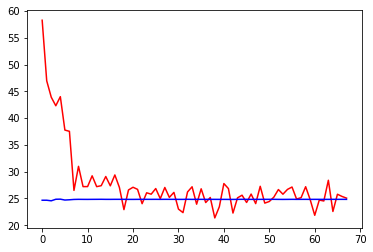

In [44]:
plt.plot(train_errors, 'r')
plt.plot(val_errors, 'b')
plt.show()

In [49]:
import cPickle as pickle
import os

import lasagne as nn

def write_model_data(model, filename):
    """Pickels the parameters within a Lasagne model."""
    PARAM_EXTENSION = 'params'
    data = nn.layers.get_all_param_values(model)
    filename = os.path.join('./', filename)
    filename = '%s.%s' % (filename, PARAM_EXTENSION)
    with open(filename, 'w') as f:
        pickle.dump(data, f)
        
write_model_data(nn_merge, 'model_30.05_00:01')

In [50]:
print epoch

68
